# explore_stochmod
### Exploratory Visualization Script for Stochmod Output

In [205]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import xarray as xr
import time
import hvplot.xarray

from cartopy import config
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cmocean
import matplotlib.ticker as mticker
from cartopy.util import add_cyclic_point
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [206]:
# Functions

def init_map(bbox,ax=None):
    """
    Quickly initialize a map for plotting
    """
    # Create Figure/axes
    #fig = plt.gcf() 
    
    #ax = fig.add_subplot(1,1,1,projection=ccrs.PlateCarree())
    if ax is None:
        ax = plt.gca()
    #ax = plt.axes(projection=ccrs.PlateCarree())
        
    
    ax.set_extent(bbox)
    
    # Add Filled Coastline
    ax.add_feature(cfeature.COASTLINE,facecolor='k')
    
    # Add Gridlines
    gl = ax.gridlines(draw_labels=True,linewidth=0.5,color='gray',linestyle=':')
    gl.xlabels_top = gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    
    return ax
    
def find_latlon(lonf,latf,lon,lat):
    """
    Find lat and lon indices
    """
    if((np.any(np.where(lon>180)) & (lonf < 0)) or (np.any(np.where(lon<0)) & (lonf > 180))):
        print("Potential mis-match detected between lonf and longitude coordinates")
    
    klon = np.abs(lon - lonf).argmin()
    klat = np.abs(lat - latf).argmin()
    
    msg1 = "Closest lon to %.2f was %.2f" % (lonf,lon[klon])
    msg2 = "Closest lat to %.2f was %.2f" % (latf,lat[klat])
    print(msg1)
    print(msg2)
    
    return klon,klat
    

def div_cint(var):
    """
    Automatically Set diverging colorbar based on min/max value
    """
    valmax = np.around(np.nanmax(var))
    valmin = np.around(np.nanmin(var))
    
    if np.abs(valmax) > np.abs (valmin):
        cint = np.linspace(-1*valmax,valmax,20)
    elif np.abs(valmax) < np.abs (valmin):
        cint = np.linspace(valmin,-1*valmin,20)
    
    return cint

In [207]:
# User Input Variables

# Set Point
lonf    = -30
latf    = 50

# Experiment Settings
entrain  = 1 # 0 = no entrain; 1 = entrain
hvarmode = 2 # 0 = fixed mld ; 1 = max mld; 2 = clim mld 
funiform = 2 # 0 = nonuniform; 1 = uniform; 2 = NAO-like

# Autocorrelation Parameters
kmon       = 2                 # Lag 0 base month
lags       = np.arange(0,61,1) # Number of lags to include
detrendopt = 0                 # Detrend before autocorrelation

# Bounding Box for visualization
lonW = -80
lonE = 20
latS = -20
latN = 90
bbox = [lonW,lonE,latS,latN]

# Paths
projpath = "/Users/gliu/Downloads/02_Research/01_Projects/01_AMV/02_stochmod/"
scriptpath = projpath + '03_Scripts/stochmod/'
datpath = projpath + '01_Data/'
outpath = projpath + '02_Figures/20200721/'


In [208]:
# Load Damping Data
damppath = '/Users/gliu/Downloads/02_Research/01_Projects/01_AMV/01_hfdamping/01_Data/'
dampmat = 'ensavg_nhflxdamping_monwin3_sig020_dof082_mode4.mat'
loaddamp = loadmat(damppath+dampmat)
lon = np.squeeze(loaddamp['LON1'])
lat = np.squeeze(loaddamp['LAT'])
damping = loaddamp['ensavg']

print("Damping Array shape: "+ str(damping.shape))

Damping Array shape: (288, 192, 12)


In [209]:
# Load MLD Data
mld      = np.load(datpath+"HMXL_hclim.npy") # Climatological MLD
kprevall = np.load(datpath+"HMXL_kprev.npy") # Entraining Month

mld.shape,kprevall.shape

((288, 192, 12), (288, 192, 12))

In [210]:
# Load Experimental data
sst = np.load(datpath+"stoch_output_1000yr_funiform%i_entrain%i_hvar%i.npy"%(funiform,entrain,hvarmode))
forcing = np.load(datpath+"stoch_output_1000yr_funiform%i_Forcing.npy"%(funiform))
lonr = np.load(datpath+"lon.npy")
latr = np.load(datpath+"lat.npy")

sst.shape, forcing.shape

((81, 117, 12000), (81, 117, 12000))

In [211]:
# Make data into dataframe
timecft = xr.cftime_range(start="0000-01-01",end="0999-12-01",freq="MS",calendar="noleap") 

da = xr.DataArray(np.transpose(sst,(1,0,2)),
                  dims=["lat","lon","time"],
                  coords={"lat":latr,"lon":lonr,"time":timecft}
                 )

In [212]:
#da.mean("time").hvplot()
da.hvplot(groupby='time', width=600, widget_type='scrubber', widget_location='bottom')

Column
    [0] HoloViews(DynamicMap, widget_location='bottom', widget_type='scrubber')
    [1] Row
        [0] HSpacer()
        [1] WidgetBox
            [0] Player(end=11999, width=550)
        [2] HSpacer()

In [213]:
da.hvplot.image('lon', 'lat',
                    width=800, height=450,
                    widget_type='scrubber', widget_location='bottom')

Column
    [0] HoloViews(DynamicMap, widget_location='bottom', widget_type='scrubber')
    [1] Row
        [0] HSpacer()
        [1] WidgetBox
            [0] Player(end=11999, width=550)
        [2] HSpacer()

/Users/gliu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.


Closest lon to -30.00 was -30.00
Closest lat to 60.00 was 59.84


/Users/gliu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """


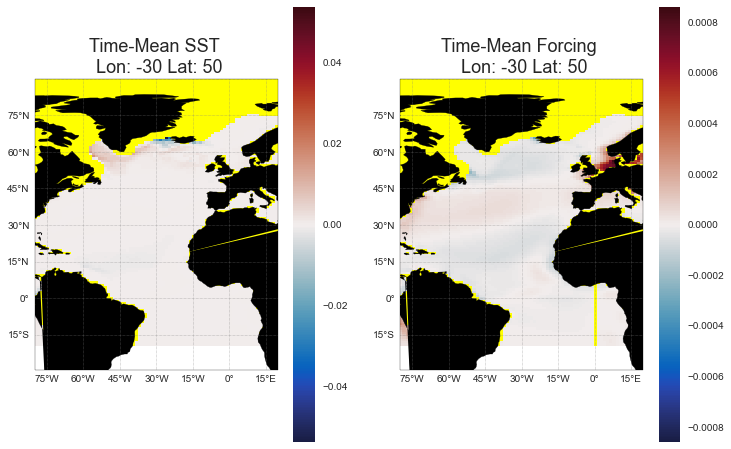

In [216]:
# Quickly Visualize Point (it isnt appearing for some reason...)

cmbal = cmocean.cm.balance
sstmean = np.nanmean(sst,2).T
forcingmean = np.nanmean(forcing,2).T

#cint = div_cint(sstmean)

fmax = np.nanmax(np.abs(forcingmean))
tmax = np.nanmax(np.abs(sstmean))


latf=60
lonf=-30

klon,klat = find_latlon(lonf,latf,lonr,latr)


fig1,axs = plt.subplots(1,2,figsize=(12,8),subplot_kw={'projection': ccrs.PlateCarree()})
#fig = plt.figure(figsize=(12,8))

# Plot SST (Time Mean)
#ax1 = plt.axes(projection=ccrs.PlateCarree())
ax1 = axs[0]
ax1 = init_map(bbox,ax=ax1)
pcm1 = ax1.pcolormesh(lonr,latr,sstmean,cmap=cmbal,vmin=-1*tmax,vmax=tmax)
tar = ax1.plot(lonr[klon],latr[klat],marker="+",markersize=2,label="target",color="black")
ax1.set_title("Time-Mean SST \n %s" % loc_figtitle,fontsize=18)
plt.colorbar(pcm1,ax=ax1)

ax2 = axs[1]
ax2 = init_map(bbox,ax=ax2)
#pcm2 = ax2.contourf(lonr,latr,forcingmean,cint,cmap=cmbal)
pcm2 = ax2.pcolormesh(lonr,latr,forcingmean,cmap=cmbal,vmin=-1*fmax,vmax=fmax)
tar = ax2.plot(lonr[klon],latr[klat],marker="+",markersize=2,label="target",color="black")
ax2.set_title("Time-Mean Forcing \n %s" % loc_figtitle,fontsize=18)
plt.colorbar(pcm2,ax=ax2)



/Users/gliu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: All-NaN slice encountered
  after removing the cwd from sys.path.


Closest lon to -30.00 was -30.00
Closest lat to 60.00 was 59.84


/Users/gliu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: All-NaN slice encountered
  """


0.5646981250960009

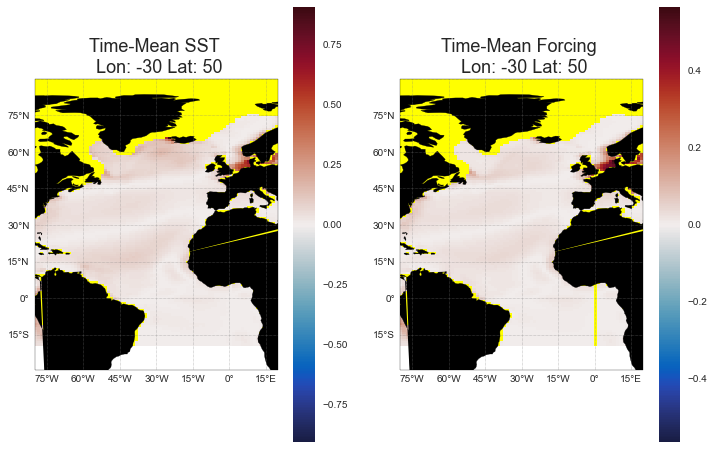

In [222]:
# PLOT MAX VALUES

cmbal = cmocean.cm.balance
sstmax     = np.nanmax(np.abs(sst),2).T
forcingmax = np.nanmax(np.abs(forcing),2).T
#cint = div_cint(sstmean)

fmax = np.nanmax(np.abs(forcingmax))
tmax = np.nanmax(np.abs(sstmax))


latf=60
lonf=-30

klon,klat = find_latlon(lonf,latf,lonr,latr)


fig1,axs = plt.subplots(1,2,figsize=(12,8),subplot_kw={'projection': ccrs.PlateCarree()})
#fig = plt.figure(figsize=(12,8))

# Plot SST (Time Mean)
#ax1 = plt.axes(projection=ccrs.PlateCarree())
ax1 = axs[0]
ax1 = init_map(bbox,ax=ax1)
pcm1 = ax1.pcolormesh(lonr,latr,sstmax,cmap=cmbal,vmin=-1*tmax,vmax=tmax)
tar = ax1.plot(lonr[klon],latr[klat],marker="+",markersize=2,label="target",color="black")
ax1.set_title("Time-Mean SST \n %s" % loc_figtitle,fontsize=18)
plt.colorbar(pcm1,ax=ax1)

ax2 = axs[1]
ax2 = init_map(bbox,ax=ax2)
#pcm2 = ax2.contourf(lonr,latr,forcingmean,cint,cmap=cmbal)
pcm2 = ax2.pcolormesh(lonr,latr,forcingmax,cmap=cmbal,vmin=-1*fmax,vmax=fmax)
tar = ax2.plot(lonr[klon],latr[klat],marker="+",markersize=2,label="target",color="black")
ax2.set_title("Time-Mean Forcing \n %s" % loc_figtitle,fontsize=18)
plt.colorbar(pcm2,ax=ax2)

fmax

Text(0.5, 1.0, 'SST (Mean:0.00)')

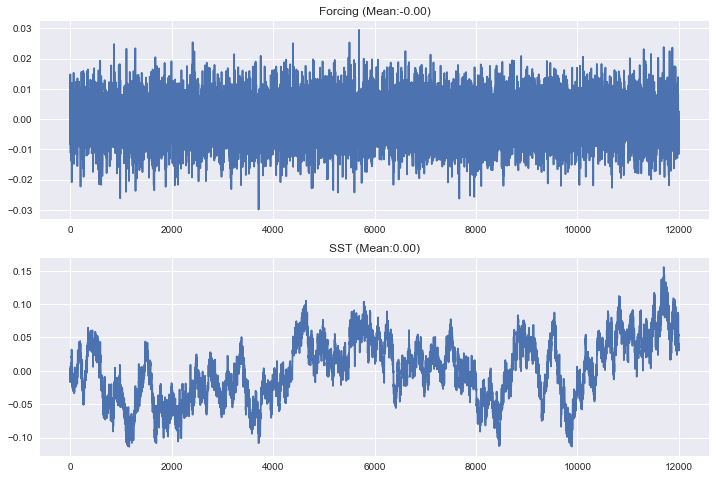

In [223]:
# Plot Timeseries for that point
fts = forcing[klon,klat,:]
sstts = sst[klon,klat,:]

tmean = np.nanmean(sstts)
fmean = np.nanmean(fts)

fig,ax = plt.subplots(2,1,figsize=(12,8))
plt.style.use('seaborn')
plt.subplot(2,1,1)
plt.plot(fts)
plt.title("Forcing (Mean:%.2f)"%(fmean))

plt.subplot(2,1,2)
plt.plot(sstts)
plt.title("SST (Mean:%.2f)"%(tmean))



Closest lon to -30.00 was -30.00
Closest lat to 60.00 was 59.84


Text(0.5, 1.0, 'Seasonal Values for MLD and $\\lambda$ (Ensemble Average) \n Lon: -30 Lat: 60')

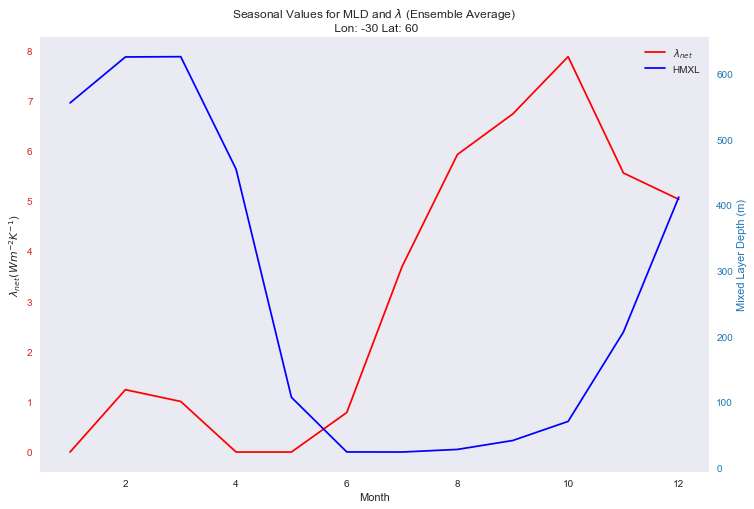

In [224]:
# Plot MLD and Damping For the same term

klon2,klat2 = find_latlon(lonf,latf,lon,lat)



mldpt = mld[klon2,klat2,:]
dampt = damping[klon2,klat2,:]


fig,ax1=plt.subplots(1,1,figsize=(12,8))

color = 'tab:red'
ax1.set_xlabel('Month')
ax1.set_ylabel('$\lambda_{net} (W m^{-2} K^{-1}$)')
ln1 = ax1.plot(np.arange(1,13,1),dampt,color='r',label=r'$\lambda_{net}$')
ax1.tick_params(axis='y',labelcolor=color)
ax1.grid(None)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Mixed Layer Depth (m)',color=color)
ln2 = ax2.plot(np.arange(1,13,1),mldpt,color='b',label=r'HMXL')
ax2.tick_params(axis='y',labelcolor=color)
ax2.grid(None)

# Set Legend
lns = ln1 + ln2
labs = [l.get_label() for l in lns]
ax1.legend(lns,labs,loc=0)

# Set Title
titlestr = 'Seasonal Values for MLD and $\lambda$ (Ensemble Average) \n Lon: ' + str(lonf) + ' Lat: '+ str(latf)
plt.title(titlestr)





In [147]:
if((np.any(np.where(lon>180)) & (lonf < 0)) or (np.any(np.where(lon<0)) & (lonf > 180))):
    print("Uh-Oh Mis-match")
else:
    print("You safe.")

You safe.


In [144]:
dampt

array([0.        , 1.24078522, 1.00647616, 0.        , 0.        ,
       0.78604021, 3.69258775, 5.92265439, 6.72940401, 7.86942263,
       5.55403855, 5.02961259])

## Forcing Visualization

In [152]:
# Load Forcing
naoforce = np.load(datpath+"NAO_Forcing_EnsAvg.npy")

# Calculate Max MLD
hmax = np.max(mld,axis=2)
hDJFM = np.nanmean(mld[:,:,[11,0,1,2]],axis=2)
# Apply Unit Conversions
dt   = 3600*24*30
cp0  = 3850
rho  = 1000
hfix = 50 

fappliedmax = naoforce*dt/cp0/rho/hmax
fappliedDJFM = naoforce*dt/cp0/rho/hDJFM
fappliedfixed = naoforce*dt/cp0/rho/hfix

# Set Colorbars and Contour Intervals
cmbal = cmocean.cm.balance
cmbal.set_bad(color='yellow')
cmdens = cmocean.cm.dense
cmdens.set_bad(color='yellow')
cint = np.arange(-45,47,2)

/Users/gliu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  


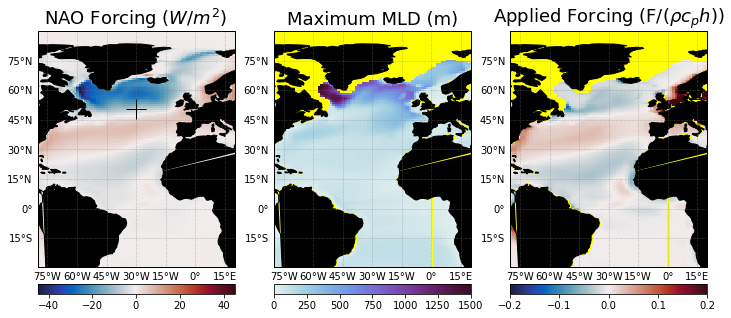

In [160]:
#Trying to Visualize the Raw NHFLX Forcing, MLD Cycle, and Applied Forcing (MLD MAX)

#import matplotlib.axes as maxes 


#fig1 = plt.figure(figsize=(12,8))
#fig1 = plt.figure(figsize=(12,8))
fig1,axs = plt.subplots(1,3,figsize=(12,8),subplot_kw={'projection': ccrs.PlateCarree()})

# Add first figure (NAO Forcing Plot, ax1)
axs[0] = axs[0]
axs[0] = init_map(bbox,ax=axs[0])
#pcm = ax1.pcolormesh(lonr,latr,naoforce.T,cint=cint,cmap=cmbal)
pcm = axs[0].pcolormesh(lon,lat,naoforce.T,cmap=cmbal,vmin=-45,vmax=45)
tar = axs[0].plot(lonr[klon],latr[klat],marker="+",markersize=20,label="target",color="black")
axs[0].set_title("NAO Forcing $(W/m^2)$",fontsize=18)
#divider = make_axes_locatable(axs[0])
#cax = divider.append_axes("right",size="5%",pad=.005,axes_class=maxes.Axes)
fig1.colorbar(pcm,ax=axs[0],orientation="horizontal",fraction=0.046,pad=0.04)

#ax2 = fig1.add_subplot(1,2,2)
axs[1] = init_map(bbox,ax=axs[1])
pcm2 = axs[1].pcolormesh(lon,lat,hmax.T,cmap=cmdens,vmin=0,vmax=1500)
axs[1].set_title("Maximum MLD (m)",fontsize=18)
fig1.colorbar(pcm2,ax=axs[1],orientation="horizontal",fraction=0.046,pad=0.04)

ax3 = axs[2]
ax3 = init_map(bbox,ax=ax3)
pcm3 = ax3.pcolormesh(lon,lat,fapplied.T,cmap=cmbal,vmax=-0.2,vmin=0.2)
fig1.colorbar(pcm3,ax=ax3,orientation="horizontal",fraction=0.046,pad=0.04)
ax3.set_title(r"Applied Forcing (F/$(\rho c_p h)$)",fontsize=18)
#plt.tight_layout()

plt.savefig(outpath+"NAO_Forcing_Magnitude_Panels_hmax.png",dpi=200)

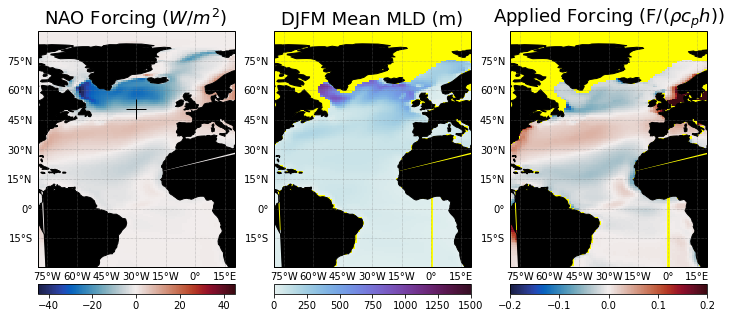

In [162]:
#Trying to Visualize the Raw NHFLX Forcing, MLD Cycle, and Applied Forcing (MLD WINTER AVERAGE)

#import matplotlib.axes as maxes 



#fig1 = plt.figure(figsize=(12,8))
#fig1 = plt.figure(figsize=(12,8))
fig1,axs = plt.subplots(1,3,figsize=(12,8),subplot_kw={'projection': ccrs.PlateCarree()})

# Add first figure (NAO Forcing Plot, ax1)
axs[0] = axs[0]
axs[0] = init_map(bbox,ax=axs[0])
#pcm = ax1.pcolormesh(lonr,latr,naoforce.T,cint=cint,cmap=cmbal)
pcm = axs[0].pcolormesh(lon,lat,naoforce.T,cmap=cmbal,vmin=-45,vmax=45)
tar = axs[0].plot(lonr[klon],latr[klat],marker="+",markersize=20,label="target",color="black")
axs[0].set_title("NAO Forcing $(W/m^2)$",fontsize=18)
#divider = make_axes_locatable(axs[0])
#cax = divider.append_axes("right",size="5%",pad=.005,axes_class=maxes.Axes)
fig1.colorbar(pcm,ax=axs[0],orientation="horizontal",fraction=0.046,pad=0.04)

#ax2 = fig1.add_subplot(1,2,2)
axs[1] = init_map(bbox,ax=axs[1])
pcm2 = axs[1].pcolormesh(lon,lat,hDJFM.T,cmap=cmdens,vmin=0,vmax=1500)
axs[1].set_title("DJFM Mean MLD (m)",fontsize=18)
fig1.colorbar(pcm2,ax=axs[1],orientation="horizontal",fraction=0.046,pad=0.04)

ax3 = axs[2]
ax3 = init_map(bbox,ax=ax3)
pcm3 = ax3.pcolormesh(lon,lat,fappliedDJFM.T,cmap=cmbal,vmax=-0.2,vmin=0.2)
fig1.colorbar(pcm3,ax=ax3,orientation="horizontal",fraction=0.046,pad=0.04)
ax3.set_title(r"Applied Forcing (F/$(\rho c_p h)$)",fontsize=18)

plt.savefig(outpath+"NAO_Forcing_Magnitude_Panels_hDJFM.png",dpi=200)

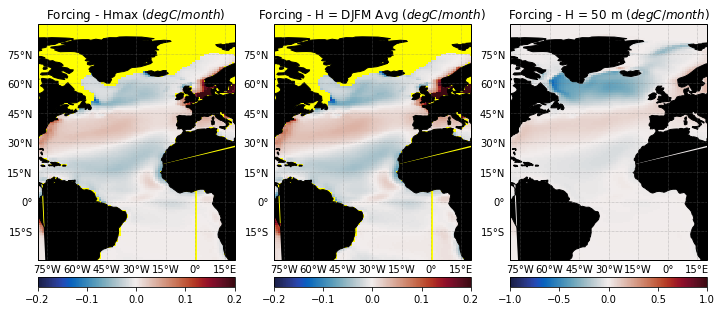

In [167]:
#Trying to Visualize forcing using 3 different type of h-eff
#import matplotlib.axes as maxes 



#fig1 = plt.figure(figsize=(12,8))
#fig1 = plt.figure(figsize=(12,8))
fig1,axs = plt.subplots(1,3,figsize=(12,8),subplot_kw={'projection': ccrs.PlateCarree()})

# Add first figure (NAO Forcing Plot, ax1)
axs[0] = axs[0]
axs[0] = init_map(bbox,ax=axs[0])
#pcm = ax1.pcolormesh(lonr,latr,naoforce.T,cint=cint,cmap=cmbal)
pcm = axs[0].pcolormesh(lon,lat,fappliedmax.T,cmap=cmbal,vmax=-0.2,vmin=0.2)
#tar = axs[0].plot(lonr[klon],latr[klat],marker="+",markersize=20,label="target",color="black")
axs[0].set_title("Forcing - Hmax $(degC/month)$",fontsize=12)
#divider = make_axes_locatable(axs[0])
#cax = divider.append_axes("right",size="5%",pad=.005,axes_class=maxes.Axes)
fig1.colorbar(pcm,ax=axs[0],orientation="horizontal",fraction=0.046,pad=0.04)

#ax2 = fig1.add_subplot(1,2,2)
axs[1] = init_map(bbox,ax=axs[1])
pcm2 = axs[1].pcolormesh(lon,lat,fappliedDJFM.T,cmap=cmbal,vmax=-0.2,vmin=0.2)
axs[1].set_title("Forcing - H = DJFM Avg $(degC/month)$",fontsize=12)
fig1.colorbar(pcm2,ax=axs[1],orientation="horizontal",fraction=0.046,pad=0.04)

ax3 = axs[2]
ax3 = init_map(bbox,ax=ax3)
pcm3 = ax3.pcolormesh(lon,lat,fappliedfixed.T,cmap=cmbal,vmax=-1,vmin=1)
fig1.colorbar(pcm3,ax=ax3,orientation="horizontal",fraction=0.046,pad=0.04)
ax3.set_title(r"Forcing - H = 50 m $(degC/month)$",fontsize=12)

plt.savefig(outpath+"NAO_Forcing_Applied_Comparison.png",dpi=200)

In [203]:
lonf = -30
latf = 60
klon2,klat2 = find_latlon(lonf,latf,lon,lat)


fappliedDJFM[klon2,klat2], fappliedmax[klon2,klat2], fappliedfixed[klon2,klat2]







Closest lon to -30.00 was -30.00
Closest lat to 60.00 was 59.84


(-0.032647522610285716, -0.028935206962211853, -0.3621563987980524)

In [227]:
np.nanmax(np.abs(forcing))

0.5646981250960009